In [1]:
# Load necessary packages
import numpy as np
import pandas as pd
import textwrap
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

# Load and clean data

    1. (1pt) Load and clean data. Feel free to copy-paste from your PS05 solution.    

In [2]:
# Load the dataset
email_df = pd.read_csv('/home/jovyan/INFO371PS/Data/lingspam-emails.csv', sep = "\t")
# Drop the NA values and print basic information
email_df = email_df.dropna(subset=['spam', 'message'])
email_df.info()
# Browse a handful of emails
email_df.sample(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2893 entries, 0 to 2892
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   spam     2893 non-null   bool  
 1   files    2893 non-null   object
 2   message  2893 non-null   object
dtypes: bool(1), object(2)
memory usage: 70.6+ KB


,spam,files,message
349,False,9-671msg1.txt,Subject: sociolinguistics mediated discourse ...
1172,False,6-266msg3.txt,Subject: bisfai deadline extension ! bisfai d...
695,False,5-1430msg1.txt,"Subject: query : "" grasshopper mind "" ? are y..."
1735,True,spmsgb164.txt,Subject: university degree programs universit...
2574,True,spmsgc117.txt,Subject: info on office 2000 pro microsoft of...


    2. (2pt) Vectorize emails so you have a DTM (I’ll refer to this as the design matrix X) and the spam/non-spam indicator y. If you don’t know how to do it, you can just use the code below:
    How many different documents (emails) and different tokens (words) do you have in these data?

In [3]:
vectorizer = CountVectorizer(binary=True)
# define vectorizer
X = vectorizer.fit_transform(email_df.message)
# vectorize your data. Note: this creates a sparse matrix,
# use .toarray() if you run into trouble
vocabulary = vectorizer.get_feature_names_out()
# in case you want to see what are the actual wordsvvv
y = email_df['spam']

In [4]:
print("There are", email_df.shape[0], "emails in the dataset.")
print("There are", len(vocabulary), "different tokens in the dataset.")

There are 2893 emails in the dataset.
There are 60925 different tokens in the dataset.


    3. (2pt) Split data into training/validation chunks.

In [5]:
# Split data into training and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)

    4. (2pt) Design a scheme to name your variables so you can understand (and you grader can understand too!) which mathematical concept it refers to. You need variables like (see Lecture notes, Ch 7.3 for more examples/explanations):
    •Pr(S=1): probability of spam
    •Pr(S=0|W=1): probability the email is not spam given it cointains the word W
    •log Pr(W=1): log probability of word present
    •ℓ(S=1|W): log-likelihood of email being spam, given vector of words it contains.
    Explain how do you name these examples values.

| Variable Name | Notation                 | Definition                                                          |
|---------------|--------------------------|--------------------------------------------------------------------|
| Pr_S1         | Pr(S = 1)           | Probability that the email is spam                               |
| Pr_S0         | Pr(S = 0)           | Probability that the email is non-spam                           |
| Pr_W1_S1      | Pr(W = 1\|S = 1)     | Probability of the word is present given the condition that the email is spam|
| Pr_W1_S0      | Pr(W = 1\|S = 0)     | Probability of the word is present given the condition that the email is non-spam |
| logPr_S1      | log Pr(S = 1)       | Log probability that the email is spam                            |
| logPr_S0      | log Pr(S = 0)       | Log probability that the email is non-spam                        |
| logPr_W1_S1   | log Pr(W = 1\|S = 1) | Log probability that the word is present in spam emails             |
| logPr_W1_S0   | log Pr(W = 1\|S = 0) | Log probability that the word is present in non-spam emails         |
| logPr_S1_W1   | log Pr(W = 1\|S = 1) | Log probability that the email is spam given the condition that the word is present |
| logPr_S0_W1   | log Pr(W = 1\|S = 0) | Log probability that the email is non-spam given the condition that the word is present |
| L_S1          | Pr(S = 1\|W)         | Log-likelihood for spam                                            |
| L_S0          | Pr(S = 0\|W)         | Log-likelihood for non-spam                                        |

# Naïve Bayes

    1. (4pt) Here is a small excerpt from the initial DTM (before you split it into training/validation), corresponding to rows 983 to 985, and to columns 40,042–40,046:
    What do these numbers show:

    (a) which emails do the rows correspond to?

In [6]:
# Print out the messages corresponds to rows 983 to 985
print("The rows corresponds to the emails at indices 983 to 985:")
email_df.message[982:985]

The rows corresponds to the emails at indices 983 to 985:


982    Subject: summary : parsing of ambiguous sequen...
983    Subject: re : sapir - whorf and what to tell s...
984    Subject: call for contributions  call for cont...
Name: message, dtype: object

    (b) Which words do the columns correspond to?

In [7]:
# Find the corresponding words to the columns 40,042 to 40,046
vocabulary[40041:40046]

array(['nooteboom', 'nootka', 'nope', 'nor', 'nora'], dtype=object)

The words the columns correspond to are: "nootka", "nope", "nor", "nora"

    (c) What do the “1”-s in the middle of the table mean?

In [8]:
# Extract the corresponding rows and columns
X[982:985, 40041:40046].toarray()

array([[0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0]])

The first 1 in the table indicates that the presence of word "nootka" in the email at row index 984. The second 1 in the table indicates the presence of the word "nor" in the email at row index 984.

    (d) What do the zeros mean?
    Note: you should have exactly the same numbers in your analysis, this is not random.

The zeros mean that the corresponding word does not appear in the correspoinding email.

    2. (2pt) What is the accuracy of the naive model that predicts all emails into the majority category?

In [9]:
# Compute the accuracy of the naive model that predicts all emails into the majority category
count_S0 = np.size(y) - np.count_nonzero(y)
count_S1 = np.count_nonzero(y)

if count_S1 > count_S0:
  print(np.mean(y))
else:
  print(1 - np.mean(y))

0.8337366055997235


The accuracy of the naive model that predicts all emails into the majority category (non-spam emails) is about 83.37%.

    3. (3pt) Compute the unconditional (log) probability that the email is spam/non-spam, log Pr(S=1), and log Pr(S=0). These probabilities are based on the values of y(i.e. spam) alone. They do not contain information about the words in emails.

In [10]:
# Compute the log probabilities for spam/non-spam emails
Pr_S1 = np.mean(y_train == 1)
# Pr_S0 = np.mean(y_train == 0)
Pr_S0 = 1 - Pr_S1
logPr_S1 = np.log(Pr_S1)
logPr_S0 = np.log(Pr_S0)
print('Log Probability of the email being spam is:', logPr_S1)
print('Log Probability of the email being non-spam is:', logPr_S0)

Log Probability of the email being spam is: -1.790895538288791
Log Probability of the email being non-spam is: -0.1824944325831309


    4. (8pt) For each word w, compute the (log) probability that the word is present in spam emails, log Pr(W=1|S=1), and (log) probability that the word is present in non-spam emails, log Pr(W= 1|S=0). These probabilities can easily be calculated from counts of how many times these words are present for each class.
    Hint: these computations are based on your BOW-s X. Look at ways to sum along columns in this matrix.

In [11]:
# Compute the Pr(W=1|S=1) and Pr(W=1|S=0)
Pr_W1_S1 = np.mean(X_train[y_train == 1], axis = 0)
Pr_W1_S0 = np.mean(X_train[y_train == 0], axis = 0)
# Compute the log of Pr(W=1|S=1) and Pr(W=1|S=0)
logPr_W1_S1 = np.log(Pr_W1_S1)
logPr_W1_S0 = np.log(Pr_W1_S0)
# Print following results
logPr_W1_S1, logPr_W1_S0

(matrix([[-1.12752363, -1.12752363, -5.95583737, ...,        -inf,
          -5.95583737,        -inf]]),
 matrix([[-1.8308972 , -2.94911796, -7.56423848, ..., -7.56423848,
                 -inf,        -inf]]))

    5. (1pt) What should be the dimension of your log Pr(W=1|S=0)and log Pr(W=1|S=0)vectors?
    Explain!

In [12]:
# Print the shape of the log Pr(W=1|S=0)
logPr_W1_S0.shape

(1, 60925)

In [13]:
# Print the shape of the log Pr(W=1|S=1)
logPr_W1_S1.shape

(1, 60925)

The dimension should be 1 row with 60925 columns. The 1 row holds the probabilities for each of the 60925 words.

    6. (10pt) For both classes, S=1 and S=0, compute the log-likelihood that the email belongs to this class. Log-likelihood is given as (7.3.20 and 7.3.21, page 270 for now) in lecture notes, and the equations in Schutt “Doing Data Science”, page 102. 
    Computing the likelihoods involves sums of the previously computed probabilities, log Pr(W=1|S), and BOW elements xij. Start by doing this by whatever way you can get it done (e.g. loops). The most important thing is that you understand what you do!
    But if you want to write efficient code, use matrix product instead (it is ∼1000×faster than loops). See Lecture Notes (7.30.30) for how to do it with matrix product. You can also check out np.apply_along_axis as an alternative way to do it.

In [14]:
# Compute log Pr(W=1|S=1) and log Pr(W=1|S=0)
L_S1 = X_val @ logPr_W1_S1.T + logPr_S1
L_S0 = X_val @ logPr_W1_S0.T + logPr_S0 

In [15]:
logPr_W1_S1

matrix([[-1.12752363, -1.12752363, -5.95583737, ...,        -inf,
         -5.95583737,        -inf]])

    7. (2pt) How many log-likelihoods you have to compute? Explain why do you have to have this many log-likelihoods.

In [16]:
# Find the total number of log-likelihoods 
L_S1.shape[0] + L_S0.shape[0]

1158

1158 log-likelihoods were computed. This is because there are 579 emails in the validation data and 2 log-likelihoods for each emails to make predictions. 579 * 2 = 1158.

    8. (7pt) Based on the log-likelihoods, predict the class S=1 or S=0 for each email in the validation set.

In [17]:
# Make predictions based on the log-likelihoods and make them 1/0
prediction = L_S1 > L_S0
prediction = prediction * 1

    9. (3pt) Print the resulting confusion matrix and accuracy (feel free to use existing libraries).

In [18]:
# Print the confusion matrix and accuracy
print("Confusion Matrix:")
print(confusion_matrix(y_val, prediction))
print("Accuracy:")
print(accuracy_score(y_val, prediction))

Confusion Matrix:
[[484   0]
 [ 81  14]]
Accuracy:
0.8601036269430051


    10. (5pt) If your results are like mine, you can see that the results are not impressive at all, your model works no better than the naive guess. Explain why do you get such mediocre results.
    Hint: this is related to infinites, where are those coming from, and why they make the model useless? See also the smoothing-related discussion in Lecture Notes at the end of the Naive Bayes (Section 7.3.3), before Example 7.3.
    Note: just explain, but do not do anything about it! We’ll attack the problem in the next question with smoothing.

The not impressive results are due to the number of -infinity values in the log Pr(W = 1|S = 0) and log Pr(W = 1|S = 1). The -infinity values come from using log and because these log values are so small, we cannot determine whether Pr(W = 1|S = 0) or Pr(W = 1|S = 1) is larger to make an accurate prediction on the emails.

Rare words that only occur in one class (spam or non spam) are categorized as having a 100% probability for the class they belong in and 0% probability for the one they're not in. Using log-likelihood only shifts the issue from zero-likelihood to minus-infinity-log-likelihood, which is no help. This makes the model useless because the other words in the text play no role - zero/negative infinity remains zero/negative infinity even when multiplied by other positive probabilities.

# Add smoothing

    1. (2pt) As you will be doing validation below, your first task is to mold what you did above into two functions: one for fitting and another one for predicting. You can mostly copy-paste your code from above.

In [19]:
# Create a function that add smoothing to the model
def fitting(X_train, y_train, alpha):
    total_spam = (y_train == 1).sum()
    total_non_spam = (y_train == 0).sum()
    
    logPr_S1 = np.log((total_spam + alpha) / (total_spam + total_non_spam + 2 * alpha))
    logPr_S0 = np.log((total_non_spam + alpha) / (total_spam + total_non_spam + 2 * alpha))
    
    logPr_W1_S1 = np.log((np.sum(X_train[y_train == 1], axis = 0) + alpha) / (total_spam + 2 * alpha))
    logPr_W1_S0 = np.log((np.sum(X_train[y_train == 0], axis = 0) + alpha) / (total_non_spam + 2 * alpha))
    
    return logPr_S1, logPr_S0, logPr_W1_S1, logPr_W1_S0

    2. (18pt) Add smoothing to the model. Smoothing amounts to assuming that we have “seen” every possible word α⩾0 times already, in both spam and non-spam emails. Note that αdoes not have to be an integer, and typically the best α<1.
    What you have to do is to re-compute the probabilities log Pr(S), log Pr( ̄S), log Pr(w|S), log Pr(w| ̄S), the predictions part will remain unchanged. So you should update your fitting function by adding an additional argument αto it, and modify the probabilities accordingly. (And you use only training data for this.)
    See Lecture Notes 7.3.2; Example 7.3 (page 274); and Schutt p 103 and p 109 for more explanations.

In [20]:
# Make a function for predicting
def predicting(X_val, y_val):
    L_S1 = logPr_S1 + X_val @ logPr_W1_S1.T
    L_S0 = logPr_S0 + X_val @ logPr_W1_S0.T
    
    prediction = (L_S1 > L_S0) * 1
    return prediction

Fitting function is in 3.1.

    3. (5pt) Use your updated model for predictions with a few different α-values (on validation data) and report the corresponding confusion matrix and accuracy.
    A well-implemented algorith should not spend more than a few seconds on both fitting and predicting. However, more important that you understand what you are doing!

In [21]:
# Use the updated model for predictions with alpha value of 1
logPr_S1, logPr_S0, logPr_W1_S1, logPr_W1_S0 = fitting(X_train, y_train, 1) 
# Compute confusion matrix and accuracy
cm = confusion_matrix(y_val, predicting(X_val, y_val))
accuracy = accuracy_score(y_val, predicting(X_val, y_val))
cm, accuracy

(array([[422,  62],
        [  0,  95]]),
 0.8929188255613126)

In [22]:
# Use the updated model for predictions with alpha value of 0.5
logPr_S1, logPr_S0, logPr_W1_S1, logPr_W1_S0 = fitting(X_train, y_train, 0.5)
# Compute confusion matrix and accuracy
cm = confusion_matrix(y_val, predicting(X_val, y_val))
accuracy = accuracy_score(y_val, predicting(X_val, y_val))
cm, accuracy

(array([[459,  25],
        [  0,  95]]),
 0.9568221070811744)

    4. (5pt) Use validation to find the best smoothing parameter α.
    You can just run a loop over different values, but start with very small values (10−8, 10−7, 10−6 up to perhaps 10).
    Note: this is fairly fast if your algorithm is fast. But even if your algorithm is slow, do the best you can!
    If your results are like mine, your best accuracy will be >99.5%. (But this result is random!)

In [23]:
best_score = 0
best_alpha = 0
scores = []
alphas = []
# Loop over different alpha values and find the best accuracy and best alpha value
for n in range(-8, 2):
    alpha = 10**n
    logPr_S1, logPr_S0, logPr_W1_S1, logPr_W1_S0 = fitting(X_train, y_train, alpha)
    score = accuracy_score(y_val, predicting(X_val, y_val))
    if score > best_score:
        best_score = score
        best_alpha = alpha
    scores.append(score)
    alphas.append(alpha)

In [24]:
print('The best accuracy is:', best_score)
print('The best alpha value is:', best_alpha)

The best accuracy is: 0.9948186528497409
The best alpha value is: 0.001


    5. (2pt) Plot how accuracy depends on α. Use log-scale for α!

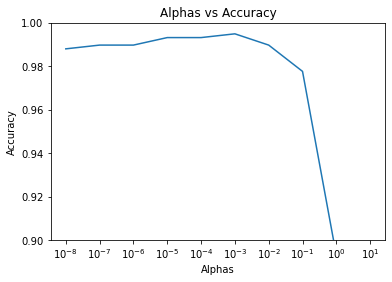

In [25]:
# Plot the accuracy vs. alpha using the log sclae for alpha
_ = plt.plot(alphas, scores)
_ = plt.xscale('log')
_ = plt.ylim(0.9, 1)
_ = plt.xticks(alphas)
_ = plt.title("Alphas vs Accuracy")
_ = plt.xlabel("Alphas")
_ = plt.ylabel("Accuracy")

# Interpretation

Naive Bayes is interpretable in a little similar fashion like linear regression. But in only a little similar fashion. Namely, we can find the words that are the best predictors that an email is spam, and the best predictors that email is non-spam. And we want to look at reasonably common words only, say more frequent than 10 times in the data.

    1. (10pt) Which words are the best predictors that an email is spam? These are the word where Pr(S=1|W=1)is large and Pr(S=0|W=1)is small, or to put it differently, where log Pr(S=1|W=1)−log Pr(S=0|W=1)is large.
    Explain why this is the case.
    Hint: you may re-check the concept of log-likelihood and how that is used for prediction.
    Hint 2: you may imagine you receive 60k 1-word emails (one for each word in your vocabulary). Which ones are most likely spam, and which ones are least likely spam?

In [26]:
# Fit with the best performing model
logPr_S1, logPr_S0, logPr_W1_S1, logPr_W1_S0 = fitting(X_train, y_train, best_alpha)
# Compute log Pr(S = 1|W = 1) and log Pr(S = 0|W = 1)
logPr_S1_W1 = logPr_W1_S1 + logPr_S1
logPr_S0_W1 = logPr_W1_S0 + logPr_S0
# Compute the difference between the two log probabilities
difference = logPr_S1_W1 - logPr_S0_W1
difference = np.array(difference)
# Convert vocabulary to array
vocab = np.array(vocabulary)
# Find the predictors 
predictors = vocab[np.argsort(-difference)]
best_predictors = predictors[0, :5]
print('The words that are the best predictors for whether an email is a spam or not:', best_predictors)

The words that are the best predictors for whether an email is a spam or not: ['bonus' 'profits' 'investment' 'fantastic' 'mlm']


To find the best predictors of whether an email is a spam or not, we want difference between $log(Pr(S = 1|W = 1))$ and $log(Pr(S = 0|W = 1))$ as large as possible. This is because it means that given a word, the email is significantly more likely to become a spam than non-spam. To calculate it, it is necessary to know $log(Pr(S = 1|W = 1))$ and $log(Pr(S = 0|W = 1))$

To calculate the two necessary log probabilities, $log(Pr(S = 1|W = 1))$ could be rewrite as $log(Pr(W = 1|S = 1))* Pr(S = 1) / Pr(W = 1)$. Same logic, $log(Pr(S = 0|W = 1))$ can be rewrite as $log(Pr(W = 1|S = 0))* Pr(S = 0) / Pr(W = 1)$. Because both have the same denominator, we can ignore the denominator when doing the difference comparison. What we are really interested to find is the numerators on the top which is the difference between $log(Pr(W = 1|S = 1))* Pr(S = 1)$ and $log(Pr(W = 1|S = 0))* Pr(S = 0)$

Finally, to compute the numerators, $log(Pr(W = 1|S = 1))* Pr(S = 1)$ can be rewritten as $log(Pr(W = 1|S = 1)) + log(Pr(S = 1))$, and $log(Pr(W = 1|S = 0))* Pr(S = 0)$ can be rewritten as $log(Pr(W = 1|S = 0)) + log(Pr(S = 0))$

    2. (10pt) Find 10 best words to predict spam and 10 best words to predict non-spam. Comment your results.

In [27]:
# Find the indices of the 10 best words to predict spam and 10 best words to predict non-spam
best_spams_predictors = np.argsort(-difference)[0, :10]
best_non_spams_predictors = np.argsort(difference)[0, :10]

In [28]:
best_spam_words = vocab[best_spams_predictors]
print('The 10 best words to predict spams are:', best_spam_words)

The 10 best words to predict spams are: ['bonus' 'profits' 'investment' 'fantastic' 'mlm' 'earning' 'stealth'
 'relax' 'hottest' 'resell']


In [29]:
best_non_spam_words = vocab[best_non_spams_predictors]
print('The 10 best words to predict non-spams are:', best_non_spam_words)

The 10 best words to predict non-spams are: ['linguistics' 'linguistic' 'theory' 'syntax' 'deadline' 'abstract'
 'structure' 'grammar' 'committee' 'workshop']


# How many hours did you spend on this PS?

I spent about 12 hours on this problem set.